In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [4]:
data = pd.read_csv('../input/environmental-sensor-data-132k/iot_telemetry_data.csv', engine='python')

In [5]:
data

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000
...,...,...,...,...,...,...,...,...,...
405179,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001
405180,1.595203e+09,b8:27:eb:bf:9d:51,0.005882,48.500000,False,0.008660,False,0.023301,22.200000
405181,1.595203e+09,1c:bf:ce:15:ec:4d,0.004540,75.699997,True,0.007181,False,0.019076,26.600000
405182,1.595203e+09,00:0f:00:70:91:0a,0.003745,75.300003,False,0.006247,False,0.016437,19.200001


In [10]:
!pip install -q pandas-profiling[notebook]

In [13]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title='Pandas Profiling Report')
profile.to_notebook_iframe()

KeyboardInterrupt: 

# Tasks 

- The stated task is "Use ML to Determine when a Person is near IoT Device"

- As we don't have labels of time stamps where people are near the IoT device we are limited to unsupervised clustering of the data

- The proximity of a person could affect the recorded parameters in the following ways:

-- Would CO levels be impacted by the presence of an individual? Perhaps, if they are breathing air near the sensor the CO will stick to their Haemoglobin permanently (this is how Carbon Monoxide poisons you) effectively scrubbing some of it from the atmosphere like a filter and leading to detectable reduction in CO ppm

-- Humidity might increase if a person is exhaling into the room

-- Light levels might drop if a person is occluding the light sensor

-- LPG levels might drop if a person breathes it in and thereby filters it from the local atmosphere

-- The movement of an individual near to a sensor would create detectable motion, though some information about other sources of motion/vibration would be needed to attribute it to a nearby person

-- Again, smoke levels could be reduced by the filtering effect of a persons lungs or increased if a person lights up a cigarette infront of the smoke sensor

-- The ambient temperature might be increase by the presence of a person next to the temperature sensor for a period of time

# Approach

- Lets plot the time series again with a more meaningful time scale (time of day might indicate when people are more likely to be nearby)

- Lets find out if there are any daily patterns the data

- Attempt to perform clustering on windows of time series data to define plausible "humans are nearby" intervals (i.e corresponding to light/motion/atmospheric/temperature changes)

# Exploring the time series

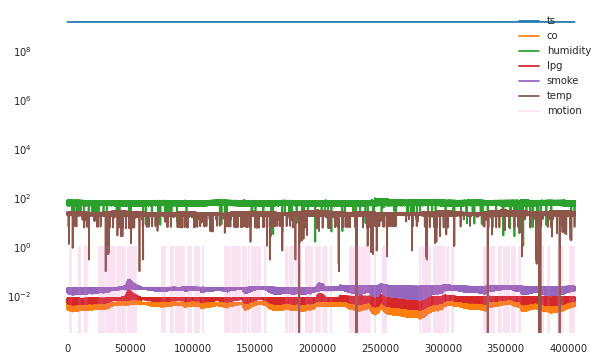

In [33]:
# plot the dataset with a log scale so everything can be viewed on the same axes effectively
ax = data.plot(logy = True, figsize = (10, 6));
data['motion'].astype(int).plot(ax=ax, alpha = 0.2);
ax.legend();
#data['light'].astype(int).plot(ax=ax, alpha = 0.2);

- From the plot above we can see a few things:
 1.  CO, LPG and smoke levels (air quality metrics) are correlated
 2.  Dramatic swings in temperature are recorded (are they real?) as well as more moderate temperature oscillations 
 3.  There are spikes in humidity
 4.  There are clusters of motion spikes interspersed with moitionless intervals

In [19]:
data.columns

Index(['ts', 'device', 'co', 'humidity', 'light', 'lpg', 'motion', 'smoke',
       'temp'],
      dtype='object')

KeyError: 'None of [RangeIndex(start=0, stop=405184, step=1)] are in the [columns]'

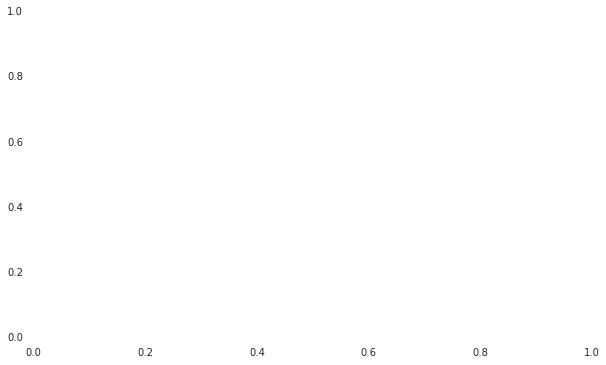

In [41]:
# It appears to be "light" 
data.plot.scatter(x = data['ts'], y = data['light'].astype(int), figsize = (10, 6))

# Any daily patterns in the data?

# Unsupervised learning to identify time series windows where humans are near